In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import implicit

In [2]:
train = pd.read_parquet('data/train.par')
test = pd.read_parquet('data/test.par')
items = pd.read_parquet('data/items.par')

In [3]:
items.drop_duplicates(subset=['item_id'], inplace=True)

In [4]:
items['brand'].replace('', '-', inplace=True)
items['brand'].fillna('-', inplace=True)

In [5]:
items['category1'] = items.category.apply(lambda x: x[0] if len(x) > 0 else pd.NA)
items['category2'] = items.category.apply(lambda x: x[1] if len(x) > 1 else pd.NA)
items['category3'] = items.category.apply(lambda x: x[2] if len(x) > 2 else pd.NA)
items['category4'] = items.category.apply(lambda x: x[3] if len(x) > 3 else pd.NA)

items['category123'] = items[['category1', 'category2', 'category3']].apply(
    lambda row: f'{row.category1} > {row.category2} > {row.category3}', axis=1)

In [6]:
items['brand_id'] = pd.Categorical(items.brand).codes
items['category123_id'] = pd.Categorical(items.category123).codes

In [7]:
items

,item_id,title,brand,category,price,category1,category2,category3,category4,category123,brand_id,category123_id
0,15018,Buzz Lightyear Jet Pack,-,"[Clothing, Shoes & Jewelry, Costumes & Accesso...",$7.41,"Clothing, Shoes & Jewelry",Costumes & Accessories,Kids & Baby,Boys,"Clothing, Shoes & Jewelry > Costumes & Accesso...",4,512
1,15576,Converse Chuck Taylor All Star Canvas Low Top ...,-,"[Clothing, Shoes & Jewelry, Men, Shoes, Fashio...",$18.29 - $189.99,"Clothing, Shoes & Jewelry",Men,Shoes,Fashion Sneakers,"Clothing, Shoes & Jewelry > Men > Shoes",4,550
2,15580,Converse Chuck Taylor All Star High Top,-,"[Clothing, Shoes & Jewelry, Men, Shoes, Fashio...",$29.55 - $160.95,"Clothing, Shoes & Jewelry",Men,Shoes,Fashion Sneakers,"Clothing, Shoes & Jewelry > Men > Shoes",4,550
3,15603,Buxton Heiress Double Cardex Wallet,Buxton,"[Clothing, Shoes & Jewelry, Women, Accessories...",$15.00,"Clothing, Shoes & Jewelry",Women,Accessories,"Wallets, Card Cases & Money Organizers","Clothing, Shoes & Jewelry > Women > Accessories",1507,565
4,15604,Buxton Heiress Ensemble Clutch Wallet,Buxton,"[Clothing, Shoes & Jewelry, Women, Accessories...",$19.99,"Clothing, Shoes & Jewelry",Women,Accessories,"Wallets, Card Cases & Money Organizers","Clothing, Shoes & Jewelry > Women > Accessories",1507,565
...,...,...,...,...,...,...,...,...,...,...,...,...
53023,50828,Bnext 3D VR Headset Virtual Reality Glasses fo...,Bnext,"[Cell Phones & Accessories, Accessories, Virtu...",,Cell Phones & Accessories,Accessories,Virtual Reality Headsets,<NA>,Cell Phones & Accessories > Accessories > Virt...,1262,485
53024,50835,"EXSHOW Car Mount,Universal Windshield Dashboar...",EXSHOW,"[Cell Phones & Accessories, Accessories, Car A...",$16.99,Cell Phones & Accessories,Accessories,Car Accessories,Car Cradles & Mounts,Cell Phones & Accessories > Accessories > Car ...,2937,473
53025,50844,Car Holder Universal Windshield Cell Phone Hol...,POY,"[Cell Phones & Accessories, Accessories, Car A...",,Cell Phones & Accessories,Accessories,Car Accessories,Car Cradles & Mounts,Cell Phones & Accessories > Accessories > Car ...,7553,473
53026,50854,Aduro Solid-Grip Phone Holder for Desk - Adjus...,Aduro,"[Cell Phones & Accessories, Accessories, Mount...",$9.99,Cell Phones & Accessories,Accessories,Mounts & Stands,Stands,Cell Phones & Accessories > Accessories > Moun...,292,477


In [8]:
train = train \
    .merge(items[['item_id', 'brand_id']], on='item_id', how='left') \
    .merge(items[['item_id', 'category123_id']], on='item_id', how='left')

In [9]:
train

,user_id,item_id,brand_id,category123_id
0,4385,13532,6290,812
1,13327,13532,6290,812
2,2785,14098,4,846
3,386,14098,4,846
4,2806,14098,4,846
...,...,...,...,...
712378,3154,49206,5630,270
712379,3551,49500,13576,298
712380,12970,50079,12335,297
712381,5337,50201,13995,298


In [10]:
test_1 = train.groupby('user_id').sample(frac=0.1)
train_1 = train[~train.index.isin(test_1.index)]

In [11]:
def train_als(interactions, feature):
    n_items = interactions[feature].max() + 1
    n_users = interactions.user_id.max() + 1

    train_ratings = interactions \
        .groupby([feature, 'user_id'], as_index=False) \
        .size() \
        .rename(columns={'size': 'rating'})

    user_sum_rating = train_ratings.groupby('user_id').rating.sum()
    train_ratings = train_ratings.join(user_sum_rating, on='user_id', rsuffix='_sum')
    train_ratings['rating_normal'] = train_ratings['rating'] / train_ratings['rating_sum']

    confidence = 1.0 + train_ratings.rating_normal.values * 30.0

    rating_matrix = sparse.csr_matrix(
        (
            confidence, 
            (
                train_ratings[feature].values,
                train_ratings.user_id.values
            )
        ),
        shape=(n_items, n_users)
    )
    rating_matrix_T = sparse.csr_matrix(
        (
            np.full(rating_matrix.nnz, 1), 
            (
                train_ratings.user_id.values,
                train_ratings[feature].values
            )
        ),
        shape=(n_users, n_items)
    )

    als = implicit.als.AlternatingLeastSquares(factors=128, 
                                               calculate_training_loss=True, 
                                               iterations=100)
    als.fit(rating_matrix)
    return als, rating_matrix_T

In [12]:
item_als, item_ratings_T = train_als(train_1, 'item_id')
brand_als, _ = train_als(train_1, 'brand_id')
category123_als, _ = train_als(train_1, 'category123_id')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
import joblib

def predict_als_for_user(user_id):
    recommendations = item_als.recommend(user_id, item_ratings_T, N=100)
    recommended_items = [x for x, _ in recommendations]
    recommended_scores = [x for _, x in recommendations]
    return user_id, recommended_items, recommended_scores

item_als_prediction_raw = joblib.Parallel(backend='multiprocessing', verbose=1, n_jobs=32)(
    joblib.delayed(predict_als_for_user)(u) for u in train.user_id.unique()
)

item_als_prediction = pd.DataFrame(item_als_prediction_raw, columns=['user_id', 'item_id', 'score'])

[Parallel(n_jobs=32)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 2000 tasks      | elapsed:    3.1s
[Parallel(n_jobs=32)]: Done 4800 tasks      | elapsed:    7.9s
[Parallel(n_jobs=32)]: Done 8400 tasks      | elapsed:   15.0s
[Parallel(n_jobs=32)]: Done 12800 tasks      | elapsed:   23.7s
[Parallel(n_jobs=32)]: Done 13490 out of 13490 | elapsed:   24.7s finished


In [14]:
import my_metrics

print('Full:', my_metrics.compute(item_als_prediction, test))
print('Test_1:', my_metrics.compute(item_als_prediction, test_1))

Full: {'recall': 0.1299258710155671, 'map': 0.0831268723451822}
Test_1: {'recall': 0.05836839751962065, 'map': 0.02639787526561018}


In [15]:
user2item_als_prediction = item_als_prediction.set_index('user_id')
item2brand = items[['item_id', 'brand_id']].set_index('item_id')
item2category_123 = items[['item_id', 'category123_id']].set_index('item_id')

def samples_to_df(user_id, positive_samples: list, negative_samples: list) -> pd.DataFrame:
    positive = pd.DataFrame({
        'user_id': user_id,
        'item_id': positive_samples,
    }).explode('item_id')
    positive['label'] = 1

    negative = pd.DataFrame({
        'user_id': user_id,
        'item_id': negative_samples,
    }).explode('item_id')
    negative['label'] = 0

    samples = pd.concat([
        positive,
        negative
    ])
    samples['user_id'] = samples.user_id.values.astype(np.int64)
    samples['item_id'] = samples.item_id.values.astype(np.int64)

    return samples


def feature_combinations(features, user_id, item_ids):
    brand_ids = item2brand.loc[item_ids].brand_id.values
    category123_ids = item2category_123.loc[item_ids].category123_id.values

    als1 = item_als
    als2 = brand_als
    als3 = category123_als

    u1 = als1.user_factors[user_id]
    i1 = als1.item_factors[item_ids]
    u2 = als2.user_factors[user_id]
    i2 = als2.item_factors[brand_ids]
    u3 = als3.user_factors[user_id]
    i3 = als3.item_factors[category123_ids]

    features['score_1'] = i1 @ u1
    features['score_2'] = i2 @ u2
    features['score_3'] = i3 @ u3

    features['score_4'] = u1 @ u2
    features['score_5'] = i2 @ u1
    features['score_6'] = i1 @ u2
    features['score_7'] = np.sum(i1 * i2 , axis=1)

    features['score_8'] = u1 @ u3
    features['score_9'] = i3 @ u1
    features['score_10'] = i1 @ u3
    features['score_11'] = np.sum(i1 * i3 , axis=1)

    features['score_12'] = u2 @ u3
    features['score_13'] = i3 @ u2
    features['score_14'] = i2 @ u3
    features['score_15'] = np.sum(i2 * i3 , axis=1)


def generate_samples_for_user(user_id):
    candidates = set(np.array(user2item_als_prediction.loc[user_id].item_id))
    valid = set(test_1[test_1.user_id == user_id].item_id.values)
    positive_samples = list(candidates.intersection(valid))
    negative_samples = list(candidates.difference(valid))

    features = samples_to_df(user_id, positive_samples, negative_samples)
    feature_combinations(features, user_id, features.item_id.values)

    return features

stage2_samples = joblib.Parallel(backend='multiprocessing', verbose=1, n_jobs=32)(
    joblib.delayed(generate_samples_for_user)(id) for id in train.user_id.unique()
)

all_samples = pd.concat(stage2_samples)
all_samples = all_samples.sample(n=len(all_samples))

[Parallel(n_jobs=32)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=32)]: Done 3040 tasks      | elapsed:    1.8s
[Parallel(n_jobs=32)]: Done 8640 tasks      | elapsed:    5.2s
[Parallel(n_jobs=32)]: Done 13410 tasks      | elapsed:    8.0s
[Parallel(n_jobs=32)]: Done 13490 out of 13490 | elapsed:    8.0s finished


In [16]:
from sklearn.model_selection import train_test_split

selected_features = [
    f'score_{(i + 1)}' for i in range(0, 15)
]
selected_cat_features = []

all_features = all_samples[selected_features + ['label']]
all_features_X = all_features.drop(columns=['label'])
all_features_Y = all_features[['label']]
X_train, X_test, y_train, y_test = train_test_split(all_features_X, all_features_Y, test_size=0.3)

value_count_01 = y_train.value_counts()
w0 = value_count_01[0] / len(y_train)
w1 = value_count_01[1] / len(y_train)
print('w_0 =', w0)
print('w_1 =', w1)

w_0 = 0.9906258604257122
w_1 = 0.009374139574287833


In [17]:
from catboost import Pool as CatBoostPool
from catboost import CatBoostClassifier
from catboost.metrics import BalancedAccuracy 
from catboost.metrics import Logloss 

cb_train_pool = CatBoostPool(X_train, y_train, cat_features=selected_cat_features)
cb_test_pool = CatBoostPool(X_test, y_test, cat_features=selected_cat_features)

cb_params = {
    'n_estimators': 500,
    'depth': 6,
    'class_weights': [w1, w0], 
    'objective': Logloss(), 
    'eval_metric': BalancedAccuracy(),
    'early_stopping_rounds': 100,
    'learning_rate': 0.1
}
cb_classifier = CatBoostClassifier(**cb_params)
cb_classifier.fit(cb_train_pool, eval_set=cb_test_pool)

0:	learn: 0.7283814	test: 0.7271770	best: 0.7271770 (0)	total: 79.9ms	remaining: 39.8s
1:	learn: 0.7286874	test: 0.7280969	best: 0.7280969 (1)	total: 109ms	remaining: 27.3s
2:	learn: 0.7290462	test: 0.7305947	best: 0.7305947 (2)	total: 139ms	remaining: 23s
3:	learn: 0.7294403	test: 0.7296306	best: 0.7305947 (2)	total: 165ms	remaining: 20.5s
4:	learn: 0.7303415	test: 0.7303609	best: 0.7305947 (2)	total: 193ms	remaining: 19.1s
5:	learn: 0.7311944	test: 0.7312260	best: 0.7312260 (5)	total: 221ms	remaining: 18.2s
6:	learn: 0.7315286	test: 0.7310776	best: 0.7312260 (5)	total: 250ms	remaining: 17.6s
7:	learn: 0.7330059	test: 0.7319470	best: 0.7319470 (7)	total: 277ms	remaining: 17s
8:	learn: 0.7328213	test: 0.7319561	best: 0.7319561 (8)	total: 304ms	remaining: 16.6s
9:	learn: 0.7334912	test: 0.7320896	best: 0.7320896 (9)	total: 333ms	remaining: 16.3s
10:	learn: 0.7338976	test: 0.7321116	best: 0.7321116 (10)	total: 363ms	remaining: 16.1s
11:	learn: 0.7340307	test: 0.7314709	best: 0.7321116 (1

('score_1', 33.07239154581811)
('score_2', 13.577861387793273)
('score_7', 7.987877503352804)
('score_3', 7.633328745810343)
('score_15', 7.041501763269221)
('score_10', 5.595703645821148)
('score_6', 4.770809573720849)
('score_5', 4.764534083037321)
('score_11', 4.292879834582379)
('score_14', 3.2143493281298663)
('score_8', 2.418226962288879)
('score_4', 2.2498725658773644)
('score_13', 1.8103869222104487)
('score_12', 1.4860257447511855)
('score_9', 0.0842503935368205)


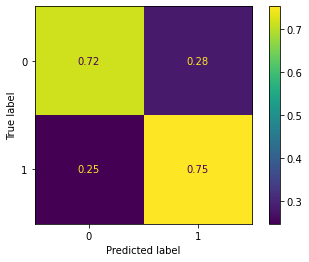

In [18]:
for x in sorted(zip(X_train.columns, cb_classifier.feature_importances_), key=lambda x: -x[1]):
    print(x)

cb_predictions = cb_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, cb_predictions, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [19]:
cb_params.update({ 'n_estimators': 60 })
cb_classifier_final = CatBoostClassifier(**cb_params)
cb_final_pool = CatBoostPool(all_features_X, all_features_Y, cat_features=selected_cat_features)
cb_classifier_final.fit(cb_final_pool)

0:	learn: 0.7283928	total: 37.7ms	remaining: 2.22s
1:	learn: 0.7289992	total: 67.1ms	remaining: 1.95s
2:	learn: 0.7292834	total: 92.9ms	remaining: 1.76s
3:	learn: 0.7294885	total: 120ms	remaining: 1.68s
4:	learn: 0.7294687	total: 148ms	remaining: 1.63s
5:	learn: 0.7297498	total: 176ms	remaining: 1.59s
6:	learn: 0.7310160	total: 203ms	remaining: 1.53s
7:	learn: 0.7313518	total: 229ms	remaining: 1.49s
8:	learn: 0.7309474	total: 258ms	remaining: 1.46s
9:	learn: 0.7313654	total: 286ms	remaining: 1.43s
10:	learn: 0.7315090	total: 315ms	remaining: 1.4s
11:	learn: 0.7319497	total: 341ms	remaining: 1.36s
12:	learn: 0.7324790	total: 367ms	remaining: 1.33s
13:	learn: 0.7329469	total: 392ms	remaining: 1.29s
14:	learn: 0.7327530	total: 425ms	remaining: 1.27s
15:	learn: 0.7327959	total: 450ms	remaining: 1.24s
16:	learn: 0.7333761	total: 476ms	remaining: 1.2s
17:	learn: 0.7334990	total: 501ms	remaining: 1.17s
18:	learn: 0.7335517	total: 526ms	remaining: 1.14s
19:	learn: 0.7334027	total: 551ms	remain

In [20]:
seen_items = train.groupby('user_id').agg({'item_id': set}).item_id

def filter_seen_items(user_id, recommended_items):
    user_seen_items = seen_items.loc[user_id]
    final_recommended_items = []
    for i in recommended_items:
        if i not in user_seen_items:
            final_recommended_items.append(i)
    return final_recommended_items


def features2recommendations(user_id, recommended_items, features):
    probs = cb_classifier_final.predict_proba(features, thread_count=1)[:, 1]
    ranks = np.argsort(-probs)
    filtered_items = filter_seen_items(user_id, recommended_items[ranks])
    return filtered_items 


def predict_als_catboost_for_user(user_id):
    recommendations = item_als.recommend(user_id, item_ratings_T, N=100)
    recommended_items = np.array([x for x, _ in recommendations])

    features = pd.DataFrame()
    feature_combinations(features, user_id, recommended_items)
    features = features[selected_features]
    
    final_recommendations = features2recommendations(user_id, recommended_items, features)
    return user_id, final_recommendations


als_catboost_prediction = joblib.Parallel(backend='multiprocessing', verbose=1, n_jobs=32)(
    joblib.delayed(predict_als_catboost_for_user)(u) for u in test_1.user_id.unique()
)

als_catboost_prediction = pd.DataFrame(als_catboost_prediction, columns=['user_id', 'item_id'])

[Parallel(n_jobs=32)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    1.4s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    3.2s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    5.6s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    8.4s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:   11.9s
[Parallel(n_jobs=32)]: Done 2386 tasks      | elapsed:   15.8s
[Parallel(n_jobs=32)]: Done 3136 tasks      | elapsed:   20.2s
[Parallel(n_jobs=32)]: Done 3986 tasks      | elapsed:   25.0s
[Parallel(n_jobs=32)]: Done 4936 tasks      | elapsed:   30.3s
[Parallel(n_jobs=32)]: Done 5986 tasks      | elapsed:   36.0s
[Parallel(n_jobs=32)]: Done 7136 tasks      | elapsed:   42.3s
[Parallel(n_jobs=32)]: Done 8386 tasks      | elapsed:   49.2s
[Parallel(n_jobs=32)]: Done 9736 tasks      | elapsed:   56.5s
[Parallel(n_jobs=32)]: Done 11186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=32)]: Done 1273

In [21]:
my_metrics.compute(als_catboost_prediction, test)

{'recall': 0.13980973560662222, 'map': 0.0934697306646899}